# Programming Assignment 3 - Unsupervised Learning and Dimensionality Reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,  mean_squared_error
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, learning_curve, validation_curve, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import InstanceHardnessThreshold, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE

%matplotlib inline

import time
from scipy.stats import kurtosis

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA, KernelPCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score, silhouette_score, completeness_score
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_selection import SelectKBest, chi2

In [68]:
## Utility functions and definitions

# Common constants
random_seed = 1

SAVE_IMAGES = True

USE_UNDERSAMPLING_IHT = 'USE_UNDERSAMPLING_IHT'
USE_UNDERSAMPLING_CNN = 'USE_UNDERSAMPLING_CNN'

DATASET_1 = 'DATASET_1'
DATASET_2 = 'DATASET_2'



# First column in both the dataset is ID column which serves no purpose in classifiation and does not tells us about the sample. 
# Therefore id column will be removed from data
def getData(id):
    if id == DATASET_1:
        data = pd.read_csv("healthcare-dataset-stroke-data.csv")
    elif id == DATASET_2:
        data = pd.read_csv("BankChurners.csv")
    data = data.iloc[:, 1:]
    return data


def print_metrics(classifier_type:str, y_test, y_pred):
    print(f'Metrics for classifier: {classifier_type}')
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix: \n {cm}')
    print(f'Accuracy score {accuracy_score(y_test, y_pred)}')
    print(f'Precision score {precision_score(y_test, y_pred)}')
    print(f'Recall score {recall_score(y_test, y_pred)}')
    print(f'ROC AUC score {roc_auc_score(y_test, y_pred)}')
    print(f'F1 score {f1_score(y_test, y_pred)}')
    
    
'''
data: dictionary
    x_values, train_scores, test_scores, train_legend, test_legend, title, xlabel, ylabel, figname
'''
def create_plot(data):
    x_values = data.get('x_values')
    train_scores = data.get('train_scores')
    test_scores = data.get('test_scores')
    test_legend = data.get('test_legend')
    train_legend = data.get('train_legend')
    figname = data.get('figname')
    
    plt.figure()
    plt.plot(x_values, train_scores, label=train_legend)
    if test_scores is not None:
        plt.plot(x_values, test_scores, label=test_legend)
    plt.title(data.get('title'))
    plt.xlabel(data.get('xlabel'))
    plt.ylabel(data.get('ylabel'))
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
    
def create_plot2(x_range=None, train_scores=None, test_scores=None, train_legend='', test_legend='', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.plot(x_range, train_scores, label=train_legend)
    if test_scores is not None:
        plt.plot(x_range, test_scores, label=test_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    

def create_curve_mean(x_range=None, train_scores=None, test_scores=None, train_legend='', test_legend='', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.plot(x_range, np.mean(train_scores, axis=1), label=train_legend)
    plt.plot(x_range, np.mean(test_scores, axis=1), label=test_legend)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    

    
def do_column_one_hot_encoding(X, col_indices):
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), col_indices)], remainder='passthrough')
    # remainder = passthrough means keep other columns on which encoding is not applied, else will get only enoded columns 
    X_encoded = ct.fit_transform(X)

    print(f'First row of X after imputation and encoding: {X_encoded[0]}')
    print(ct.get_feature_names_out())
    return X_encoded


# reference: https://www.udemy.com/course/machine-learning-with-imbalanced-data/

# reference: https://github.com/solegalli/machine-learning-imbalanced-data/blob/master/Section-04-Undersampling/04-10-Instance-Hardness-Threshold.ipynb
rf = RandomForestClassifier(n_estimators=5, random_state=1, max_depth=1)
iht = InstanceHardnessThreshold(
    estimator=rf,
    sampling_strategy=.6,  # undersamples only the majority class
    random_state=random_seed,
    n_jobs=4, # have 4 processors in my laptop
    cv=3,  # cross validation fold
)


# Reference: https://github.com/solegalli/machine-learning-imbalanced-data/blob/master/Section-04-Undersampling/04-02-Condensed-Nearest-Neighbours.ipynb
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',  # undersamples only the majority class
    random_state=0,  # for reproducibility
    n_neighbors=1,# default
    n_jobs=4)  # I have 4 cores in my laptop

def do_resampling(X, y, resampling_technique):
    print(f'Before resampling with {resampling_technique}: Shape of X: {X.shape}, Shape of y: {y.shape}')
    if resampling_technique == USE_UNDERSAMPLING_IHT:
        X_resampled, y_resampled = iht.fit_resample(X, y)
    elif resampling_technique == USE_UNDERSAMPLING_CNN:
        X_resampled, y_resampled = cnn.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y

    print(f'After resampling with {resampling_technique}: Shape of X: {X_resampled.shape}, Shape of y: {y_resampled.shape}')

    unique, counts = np.unique(y_resampled, return_counts=True)
    print(f'After resampling: value counts: {unique} : {counts}')

    print(X_resampled[0])
    
    return X_resampled, y_resampled

    
def create_loss_curve(scores=None, legend='', title='', x_label='', y_label='', figname=''):
    plt.figure()
    plt.title(title)
    plt.plot(scores, color="blue", label=legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()
    
def get_mean_score(test_scores):
    return np.mean(np.sum(test_scores, axis=1), axis=0)*fold_size

   
def do_feature_scaling(X_train, X_test, columns_to_scale):
    sc = StandardScaler()
    X_train[:, columns_to_scale] = sc.fit_transform(X_train[:, columns_to_scale])
    X_test[:, columns_to_scale] = sc.transform(X_test[:, columns_to_scale])

    X_train  = X_train.copy()
    X_test = X_test.copy()
    
    return X_train, X_test


def create_time_plot(title, xlabel, ylabel, original_times, pca_times, ica_times, grp_times, tsvd_times, figname=''):
    x_range = np.arange(0.1, 1.0, .1)
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x_range, np.sum(original_times, axis=1), color="orange", label="Full training Data")
    plt.plot(x_range, np.sum(pca_times, axis=1), color="green", label="PCA")
    plt.plot(x_range, np.sum(ica_times, axis=1), color="red", label="ICA")
    plt.plot(x_range, np.sum(grp_times, axis=1), color="blue", label="Random Projection")
    plt.plot(x_range, np.sum(tsvd_times, axis=1), color="lime", label="Truncated SVD")
    plt.legend(loc="best")
    plt.grid()
    if figname and SAVE_IMAGES:
        plt.savefig(figname)
    plt.show()

## Dataset 1 - Stroke Prediction Dataset (Kaggle)

Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [3]:
# Dataset 1 constants
# RESAMPLING_TECHNIQUE = USE_UNDERSAMPLING_IHT

In [4]:
data1 = getData(DATASET_1)

print(f'Shape of data1: {data1.shape}')

data1.head()

Shape of data1: (5110, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
print(data1["stroke"].value_counts())
print(data1["stroke"].value_counts()/len(data1))
data1.describe()

0    4861
1     249
Name: stroke, dtype: int64
0    0.951272
1    0.048728
Name: stroke, dtype: float64


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


## Data Preprocessing

### Handle missing data using imputation

In [7]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data1['bmi'] = imputer.fit_transform(data1[['bmi']])
data1

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [8]:
X1 = data1.iloc[:, :-1].values
y1 = data1.iloc[:, -1].values

print(f'Shape of X1: {X1.shape}')
print(f'Shape of y1: {y1.shape}')


# Encode categorical independent variables
print(data1.columns)
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
# skipping OneHotEncoding of binary features based on following explanation: https://stackoverflow.com/a/64377627
col_indices1 = [data1.columns.get_loc(col) for col in cols_to_encode]
print(col_indices1)

X1 = do_column_one_hot_encoding(X1, col_indices1)
print(f'Completed One Hot encoding on X1')
print(X1)


# Resampling for imbalanced datasets
X_resampled1, y_resampled1 = do_resampling(X1, y1, USE_UNDERSAMPLING_IHT)
print(f'Completed resampling on X1')
print(X_resampled1)

# Split training and test set
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled1, y_resampled1, test_size = 0.2, random_state = random_seed)
print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)
print(f'Completed train_test_split on X1')
print(X_train1)



# manually scan and check which columns after OneHotEncoding have numeric values and scale them
columns_to_scale1 = [16, 19, 20]


# Feature Scaling
X_train1, X_test1 = do_feature_scaling(X_train1, X_test1, columns_to_scale1)
X_train1

Shape of X1: (5110, 10)
Shape of y1: (5110,)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')
[0, 4, 5, 6, 9]
First row of X after imputation and encoding: [0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 67.0 0 1
 228.69 36.6]
['encoder__x0_Female' 'encoder__x0_Male' 'encoder__x0_Other'
 'encoder__x4_No' 'encoder__x4_Yes' 'encoder__x5_Govt_job'
 'encoder__x5_Never_worked' 'encoder__x5_Private'
 'encoder__x5_Self-employed' 'encoder__x5_children' 'encoder__x6_Rural'
 'encoder__x6_Urban' 'encoder__x9_Unknown' 'encoder__x9_formerly smoked'
 'encoder__x9_never smoked' 'encoder__x9_smokes' 'remainder__x1'
 'remainder__x2' 'remainder__x3' 'remainder__x7' 'remainder__x8']
Completed One Hot encoding on X1
[[0.0 1.0 0.0 ... 1 228.69 36.6]
 [1.0 0.0 0.0 ... 0 202.21 28.1]
 [0.0 1.0 0.0 ... 1 105.92 32.5]
 ...
 [1.0 0.0 0.0 ... 0 82.99

array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -1.06732673, -0.86638133],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.66694404, -0.88277431],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.4159753 ,  0.28112696],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.07989225, -1.73520904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -0.13652452, -0.06312553],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -0.84110468, -1.11227597]])

## Dataset 2 Credit Card customers (Predict Churning customers)
Source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

In [9]:
#DATASET_ID = DATASET_2
#RESAMPLING_TECHNIQUE = USE_UNDERSAMPLING_CNN

In [10]:
data2 = getData(DATASET_2)

print(f'Shape of data: {data2.shape}')

data2 = data2.rename(columns={
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1': 'Naive_bayes_mon_1', 
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2': 'Naive_bayes_mon_2'})

data2 = data2.drop(['Naive_bayes_mon_1', 'Naive_bayes_mon_2'], axis = 1)

data2.head()

Shape of data: (10127, 22)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [11]:
print(data2["Attrition_Flag"].value_counts())
print(data2["Attrition_Flag"].value_counts()/len(data2))
data2.describe()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [12]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

### Data Preprocessing

In [13]:
X2 = data2.iloc[:, 1:].values
y2 = data2.iloc[:, 0].values

print(f'Shape of X2: {X2.shape}')
print(f'Shape of y2: {y2.shape}')


# Encode categorical independent variables
print(data2.columns)
cols_to_encode2 = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
# skipping OneHotEncoding of binary features based on following explanation: https://stackoverflow.com/a/64377627
col_indices2 = [(data2.columns.get_loc(col)-1) for col in cols_to_encode2]
col_indices2


X2 = do_column_one_hot_encoding(X2, col_indices2)

# Encoding the Dependent Variable¶
le = LabelEncoder()
y2 = le.fit_transform(y2)

# Resampling for imbalanced datasets
X_resampled2, y_resampled2 = do_resampling(X2, y2, USE_UNDERSAMPLING_CNN)

#Split training and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_resampled2, y_resampled2, test_size = 0.2, random_state = 1)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

# Feature Scaling
columns_to_scale2 = [index for index in range(24, 37)]
columns_to_scale2


X_train2, X_test2 = do_feature_scaling(X_train2, X_test2, columns_to_scale2)

Shape of X2: (10127, 19)
Shape of y2: (10127,)
Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')
First row of X after imputation and encoding: [0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 0.0 1.0 0.0 0.0 0.0 45 3 39 5 1 3 12691.0 777 11914.0 1.335 1144 42 1.625
 0.061]
['encoder__x1_F' 'encoder__x1_M' 'encoder__x3_College'
 'encoder__x3_Doctorate' 'encoder__x3_Graduate' 'encoder__x3_High School'
 'encoder__x3_Post-Graduate' 'encoder__x3_Uneducated'
 'encoder__x3_Unknown' 'encoder__x4_Divorced' 'encoder__x4_Married'
 'encoder__x4_Single' 'encoder__x4_

# STEP 1: Clustering Algorithms - KMeans and EM

In [55]:
def run_kmeans(X, y, k_range):
    wcss_scores = np.zeros(len(k_range)+2)
    labels = np.zeros(len(k_range)+2)
    silhouette_scores = np.zeros(len(k_range)+2)
    homogeneity_scores = np.zeros(len(k_range)+2)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=random_seed)
        kmeans.fit(X)
        wcss_scores[k] = kmeans.inertia_
        labels = kmeans.fit_predict(X)
        silhouette_scores[k] = silhouette_score(X, kmeans.labels_)
        homogeneity_scores[k] = homogeneity_score(y, labels)
    return wcss_scores, labels, silhouette_scores, homogeneity_scores

def run_kmeans_and_plot(X, y, dataset_id, suffix='', title_update=''):
    k_range = range(2, 12)
    scores, labels, silhouette_scores, homogeneity_scores = run_kmeans(X, y, k_range)
    
    if dataset_id == DATASET_1:
        elbow_fig = 'ds1_kmeans_elbow{fsuffix}.png'.format(fsuffix=suffix)
        homog_fig = 'ds1_kmeans_homog{fsuffix}.png'.format(fsuffix=suffix)
        silh_fig = 'ds1_kmeans_silh{fsuffix}.png'.format(fsuffix=suffix)
    elif dataset_id == DATASET_2:
        elbow_fig = 'ds2_kmeans_elbow{fsuffix}.png'.format(fsuffix=suffix)
        homog_fig = 'ds2_kmeans_homog{fsuffix}.png'.format(fsuffix=suffix)
        silh_fig = 'ds2_kmeans_silh{fsuffix}.png'.format(fsuffix=suffix)
    else:
        print(f'Unknown Dataset {dataset_id}')
    
    title_elbow = 'KMeans Elbow Plot for {} {}'.format(dataset_id, title_update)
    title_silh = 'KMeans Silhouette Plot for {} {}'.format(dataset_id, title_update)
    title_homog = 'KMeans Homogeneity Score Plot for {} {}'.format(dataset_id, title_update)
    
    create_plot2(x_range=k_range, train_scores=scores[2:], test_scores=None, train_legend='WCSS Scores', test_legend='', 
                 title=title_elbow, x_label='Number of Clusters (k)', y_label='WCSS Score', figname=elbow_fig)
    
    create_plot2(x_range=k_range, train_scores=silhouette_scores[2:], test_scores=None, train_legend='Silhouette Scores', test_legend='', 
                 title=title_silh, x_label='Number of Clusters (k)', y_label='Silhouette Score', figname=silh_fig)
    
    create_plot2(x_range=k_range, train_scores=homogeneity_scores[2:], test_scores=None, train_legend='Homogeneity Scores', test_legend='', 
                 title=title_homog, x_label='Number of Clusters (k)', y_label='Homogeneity Score', figname=homog_fig)
    

def run_gaussian_mixture(X, y, k_range):
    bic = np.zeros(len(k_range)+2)
    aic = np.zeros(len(k_range)+2)
    homogeneity_scores = np.zeros(len(k_range)+2)
    for k in k_range:
        gmm = GaussianMixture(n_components=k, max_iter=1000, random_state=random_seed)
        gmm.fit(X)
        bic[k] = gmm.bic(X)
        aic[k] = gmm.aic(X)
        labels = gmm.fit_predict(X)
        homogeneity_scores[k] = homogeneity_score(y, labels)
    return bic, aic, homogeneity_scores

def run_gm_and_plot(X, y, dataset_id, figname, suffix=''):
    k_range = range(2, X.shape[1])
    bic, aic, homogeneity_scores = run_gaussian_mixture(X, y, k_range)
    
    if dataset_id == DATASET_1:
        homog_fig = 'ds1_em_homog{fsuffix}.png'.format(fsuffix=suffix)
    elif dataset_id == DATASET_2:
        homog_fig = 'ds2_em_homog{fsuffix}.png'.format(fsuffix=suffix)
    else:
        print(f'Unknown Dataset {dataset_id}')
    
    create_plot2(x_range=k_range, train_scores=bic[2:],test_scores=aic[2:], train_legend='BIC', test_legend='AIC', 
                 title='EM Plot for ' + dataset_id, x_label='Number of Clusters (k)', y_label='Score', figname=figname)
    create_plot2(x_range=k_range, train_scores=homogeneity_scores[2:], test_scores=None, train_legend='Homogeneity Scores', test_legend='', 
                 title='EM Homogeneity Scores Plot for ' + dataset_id, x_label='Number of Clusters (k)', y_label='Score', figname=homog_fig)

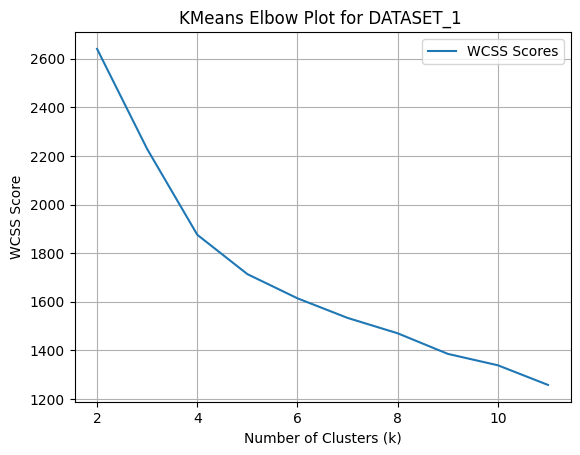

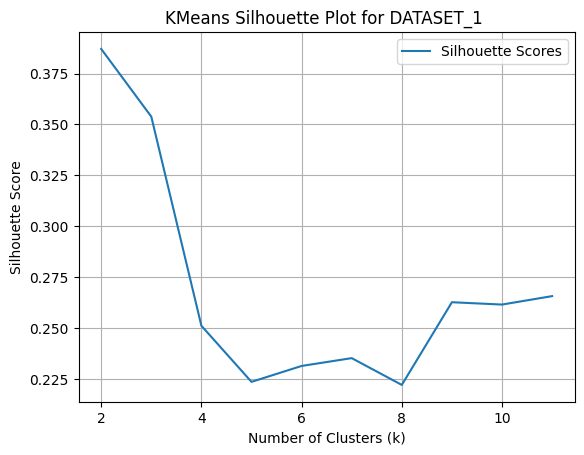

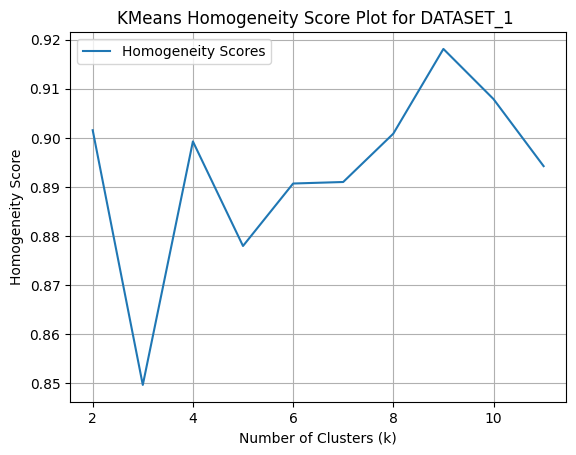

In [57]:
run_kmeans_and_plot(X_train1, y_train1, DATASET_1)

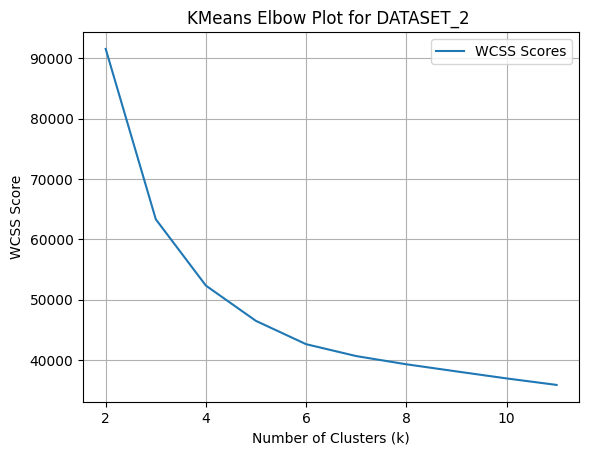

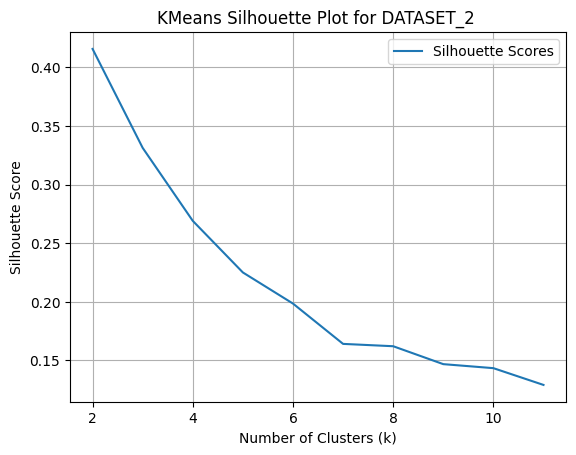

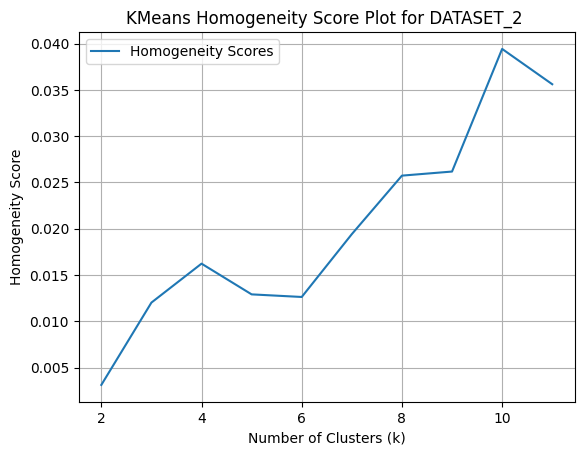

In [58]:
run_kmeans_and_plot(X_train2, y_train2, DATASET_2)

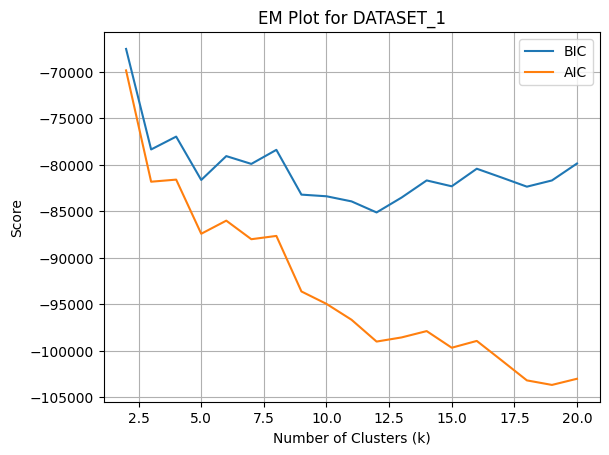

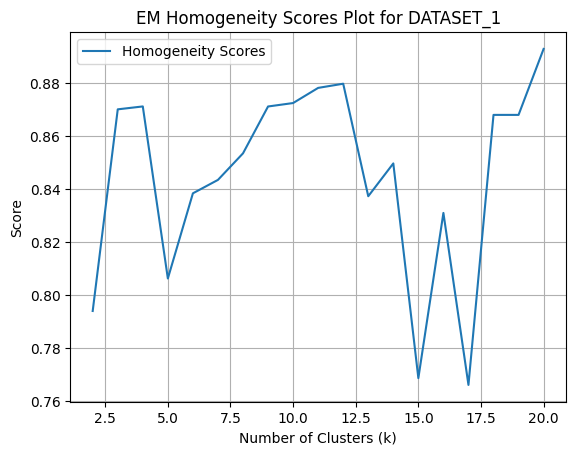

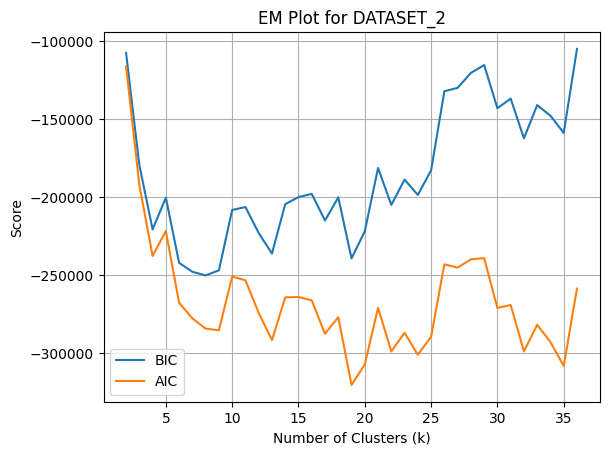

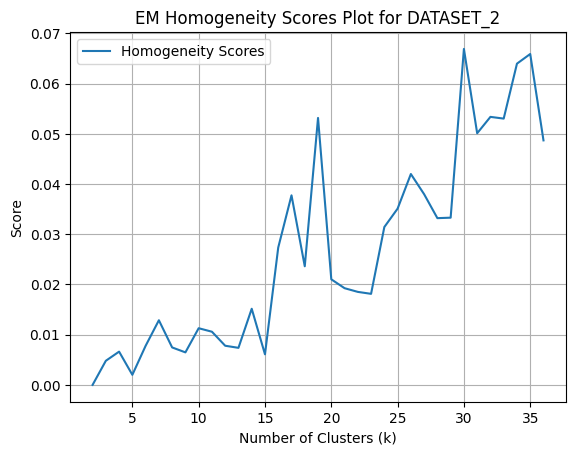

In [56]:
run_gm_and_plot(X_train1, y_train1, DATASET_1, 'ds1_gm_bic_aic.png')
run_gm_and_plot(X_train2, y_train2, DATASET_2, 'ds2_gm_bic_aic.png')

# STEP 2 Dimensionality Reduction

### Principal Component Analysis

In [18]:
def run_pca_iterative(X_train, X_test):
    dim_range = range(1, X_train.shape[1])
    print(dim_range)
    scores = np.zeros(len(dim_range)+1)
    scores = []
    for n in dim_range:
        print(n)
        pca = PCA(n_components = n, random_state=random_seed)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        scores.append(np.cumsum(pca.explained_variance_ratio_))
    return scores, dim_range

def run_pca(X_train, X_test):
    pca = PCA(random_state=random_seed)
    X_train_new = pca.fit_transform(X_train)
    print(type(pca))
    #X_test = pca.transform(X_test)
    return pca.explained_variance_ratio_, X_train_new

def print_pca_info(pca):
    print(pca.components_)
    print(pca.explained_variance_)
    print(pca.explained_variance_ratio_)
    print(pca.n_components_)
    print(pca.n_features_in_)
    print(pca.feature_names_in_)
    print(pca.explained_variance_ratio_)

def run_pca_and_plot(X_train, X_test, dataset_id, figname, plot=True):
    variances, X_train = run_pca(X_train, X_test)
    
    if plot==True:
        create_plot2(x_range=range(0, X_train.shape[1]), train_scores=variances,test_scores=None, train_legend='PCA Variance', 
                 test_legend='', title='PCA Variance Plot for ' + dataset_id, x_label='Number of dimensions', 
                 y_label='Variance Ratio', figname=figname)
    return variances, X_train

###### variance_pca_ds1, X_train_pca_ds1 = run_pca_and_plot(X_train1, X_test1, DATASET_1, 'ds1_pca.png')
variance_pca_ds2, X_train_pca_ds2 = run_pca_and_plot(X_train2, X_test2, DATASET_2, 'ds2_pca.png')

In [20]:
DR_VARIANCE_REQD = 0.95

In [21]:
def get_top_pca(X_train):
    pca = PCA(n_components = DR_VARIANCE_REQD, random_state=random_seed)
    pca.fit(X_train)
    X_train_reduced = pca.transform(X_train)
    return pca, X_train_reduced

pca_ds1, X_train_reduced_pca1 = get_top_pca(X_train1)
print(f'DataSet 1: Components after PCA: {pca_ds1.n_components_}')

pca_ds2, X_train_reduced_pca2 = get_top_pca(X_train2)
print(f'DataSet 2: Components after PCA: {pca_ds2.n_components_}')

DataSet 1: Components after PCA: 10
DataSet 2: Components after PCA: 9


In [22]:
#sns.pairplot(data=pd.DataFrame(X_train_pca_ds1))

In [23]:
#sns.pairplot(data=pd.DataFrame(X_train_pca_ds2))

### Independent Component Analysis

In [24]:
def run_ica(X_train, X_test):
    ica = FastICA(random_state=random_seed, whiten='unit-variance', max_iter=1000)
    X_train = ica.fit_transform(X_train)
    kurt = kurtosis(X_train)
    #print(kurt)
    return kurt, X_train


def run_ica_and_plot(X_train, X_test, dataset_id, figname):
    kurt, X_train = run_ica(X_train, X_test)
    
    create_plot2(x_range=range(0, X_train.shape[1]), train_scores=kurt, test_scores=None, train_legend='ICA Kurtosis', 
                 test_legend='', title='ICA Kurtosis Plot for ' + dataset_id, x_label='Number of components', 
                 y_label='Kurtosis', figname=figname)


D:\programming\python\Anaconda3\envs\py310\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


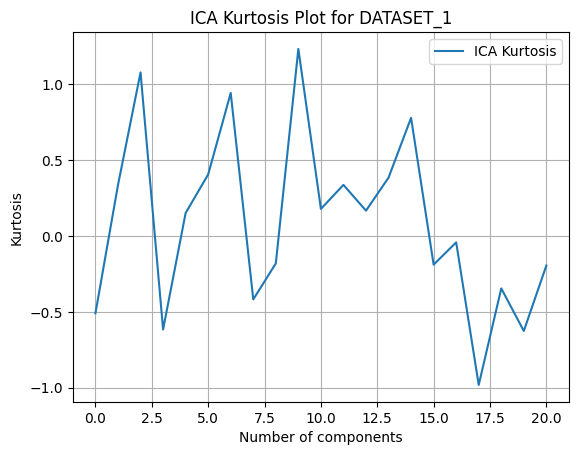

In [25]:
run_ica_and_plot(X_train1, X_test1, DATASET_1, 'ds1_ica.png')

D:\programming\python\Anaconda3\envs\py310\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


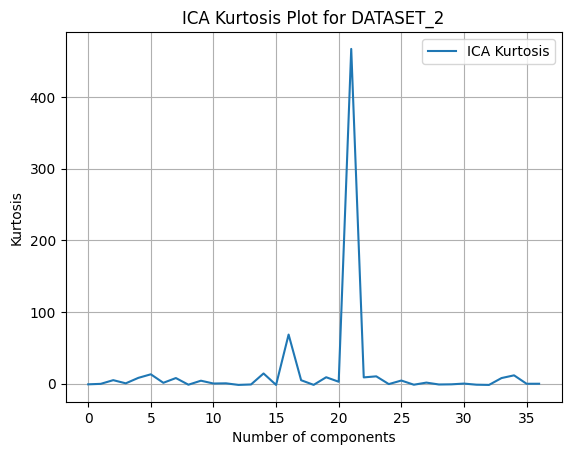

In [26]:
run_ica_and_plot(X_train2, X_test2, DATASET_2, 'ds2_ica.png')

In [27]:
def get_top_ica(X_train, n):
    ica = FastICA(n_components = n)
    ica.fit(X_train)
    X_train_reduced = ica.transform(X_train)
    return ica, X_train_reduced

ica_ds1, X_train_reduced_ica1 = get_top_ica(X_train1, 10)
print(f'DataSet 1: Components after ICA: {ica_ds1.n_components}')

ica_ds2, X_train_reduced_ica2 = get_top_ica(X_train2, 9)
print(f'DataSet 2: Components after ICA: {ica_ds2.n_components}')

DataSet 1: Components after ICA: 10
DataSet 2: Components after ICA: 9


D:\programming\python\Anaconda3\envs\py310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
D:\programming\python\Anaconda3\envs\py310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
D:\programming\python\Anaconda3\envs\py310\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


### Gaussian Randomized Projections

In [ ]:
def run_rp(X):
    n_range = range(1, X.shape[1]+1)
    errors = np.zeros(len(n_range) +1)
    for n in n_range:
        grp = GaussianRandomProjection(n_components=n, random_state=random_seed)
        x_prime = grp.fit_transform(X)
        matrix = np.linalg.pinv(grp.components_.T)
        reconstructed_matrix = np.dot(x_prime, matrix)      ## https://stackoverflow.com/questions/36566844/pca-projection-and-reconstruction-in-scikit-learn
        error = mean_squared_error(X, reconstructed_matrix)    
        errors[n] = error
    return errors, n_range

def run_rp_and_plot(X, dataset_id, figname):
    errors, n_range = run_rp(X)
    create_plot2(x_range=n_range, train_scores=errors[1:], test_scores=None, train_legend='Reconstruction Error', 
                 test_legend='', title='Gaussian Random Projection: ' + dataset_id, x_label='Number of Components', 
                 y_label='Reconstruction error', figname=figname)

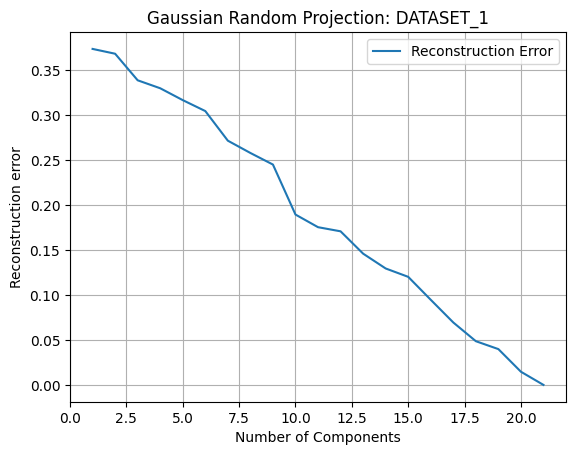

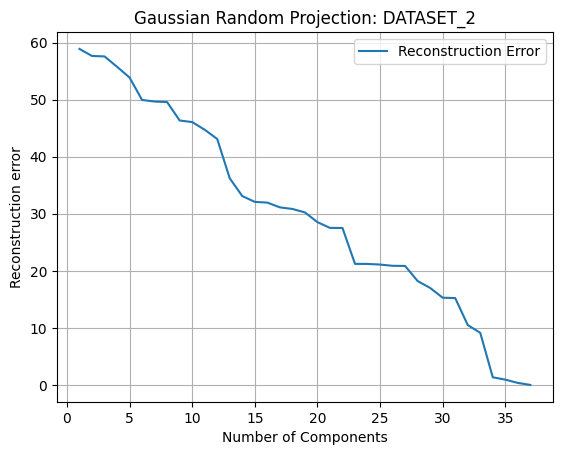

In [ ]:
run_rp_and_plot(X_train1, DATASET_1, 'ds1_rp.png')
run_rp_and_plot(X_train2, DATASET_2, 'ds2_rp.png')

In [30]:
def get_top_grp(X_train, n):
    grp = GaussianRandomProjection(n_components=n, random_state=random_seed)
    grp.fit(X_train)
    X_train_reduced = grp.transform(X_train)
    return grp, X_train_reduced

grp_ds1, X_train_reduced_grp1 = get_top_grp(X_train1, 10)
print(f'DataSet 1: Components after GRP: {grp_ds1.n_components}')

grp_ds2, X_train_reduced_grp2 = get_top_grp(X_train2, 9)
print(f'DataSet 2: Components after GRP: {grp_ds2.n_components}')

DataSet 1: Components after GRP: 10
DataSet 2: Components after GRP: 9


### Truncated SVD

In [31]:
def run_trunc_svd(X_train, X_test):
    svd = TruncatedSVD(random_state=random_seed)
    X_train_new = svd.fit_transform(X_train)
    return svd.explained_variance_ratio_, X_train_new


def run_trunc_svd_and_plot(X_train, X_test, dataset_id, figname, plot=True):
    variances, X_train = run_pca(X_train, X_test)
    
    if plot==True:
        create_plot2(x_range=range(0, X_train.shape[1]), train_scores=variances,test_scores=None, train_legend='Truncated SVD Variance', 
                 test_legend='', title='Truncated SVD Variance Plot for ' + dataset_id, x_label='Number of dimensions', 
                 y_label='Explained Variance Ratio', figname=figname)
    return variances, X_train

<class 'sklearn.decomposition._pca.PCA'>


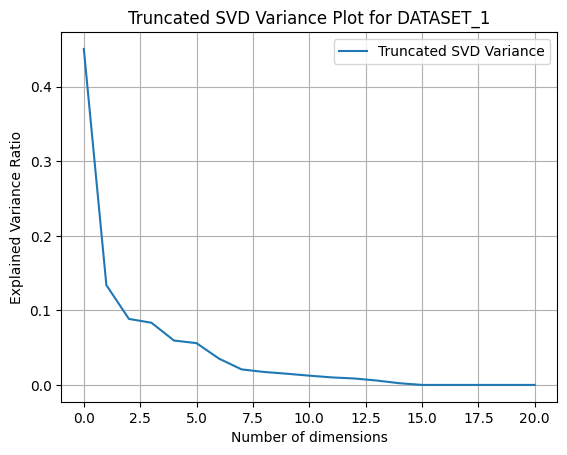

<class 'sklearn.decomposition._pca.PCA'>


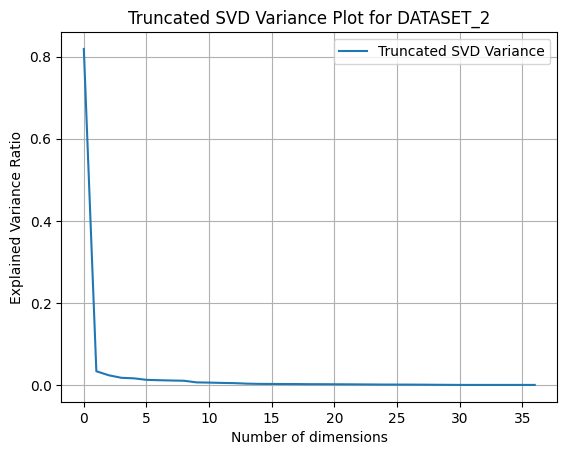

In [32]:
variance_tsvd_ds1, X_train_tsvd_ds1 = run_trunc_svd_and_plot(X_train1, X_test1, DATASET_1, 'ds1_tsvd.png')
variance_tsvd_ds2, X_train_tsvd_ds2 = run_trunc_svd_and_plot(X_train2, X_test2, DATASET_2, 'ds2_tsvd.png')

In [33]:
def get_top_tsvd(X_train, n):
    svd = TruncatedSVD(n_components = n, random_state=random_seed)
    svd.fit(X_train)
    X_train_reduced = svd.transform(X_train)
    return svd, X_train_reduced

tsvd_ds1, X_train_reduced_tsvd1 = get_top_tsvd(X_train1, 10)
print(f'DataSet 1: Components after Truncated SVD: {X_train_reduced_tsvd1.shape}')

tsvd_ds2, X_train_reduced_tsvd2 = get_top_tsvd(X_train2, 9)
print(f'DataSet 2: Components after Truncated SVD: {X_train_reduced_tsvd2.shape}')

DataSet 1: Components after Truncated SVD: (717, 10)
DataSet 2: Components after Truncated SVD: (2367, 9)


# STEP 3: Clustering after Dimensionality Reduction

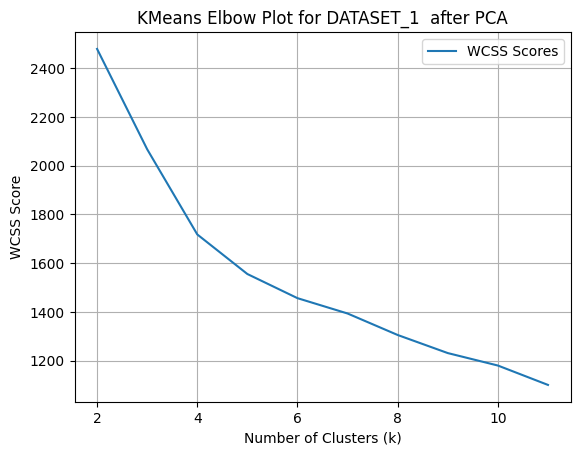

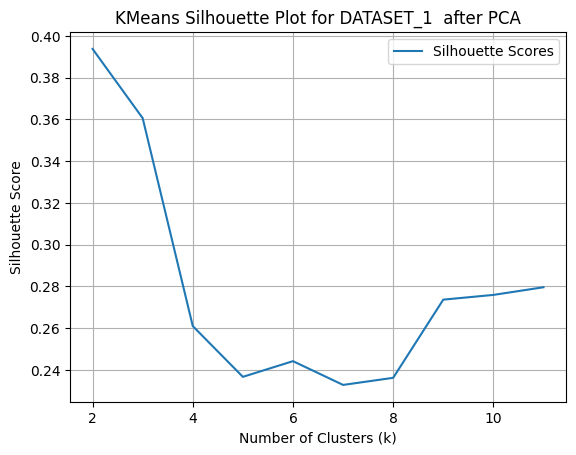

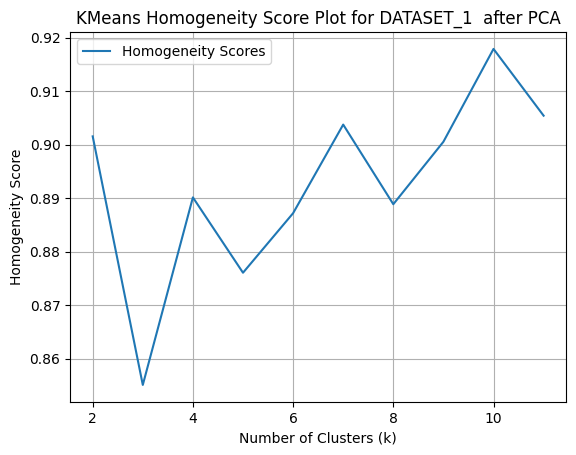

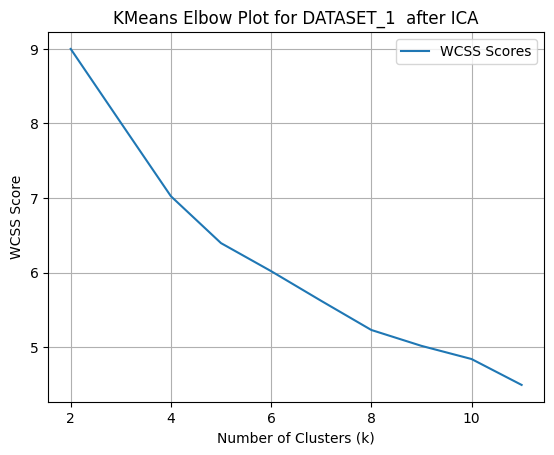

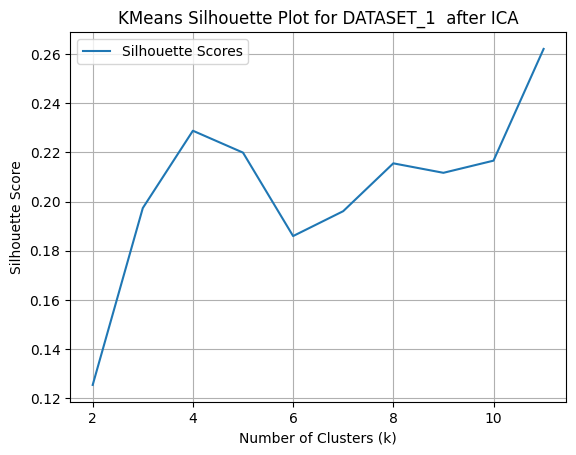

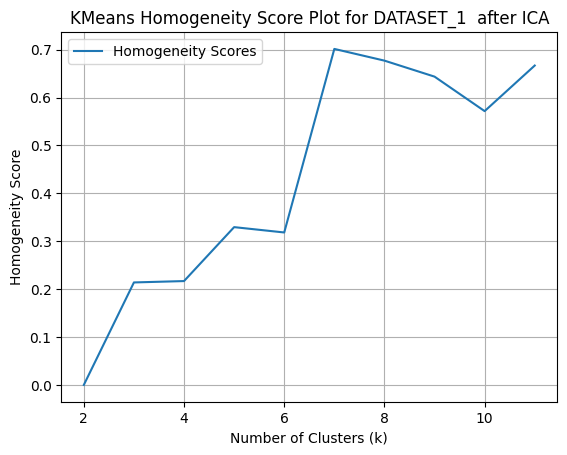

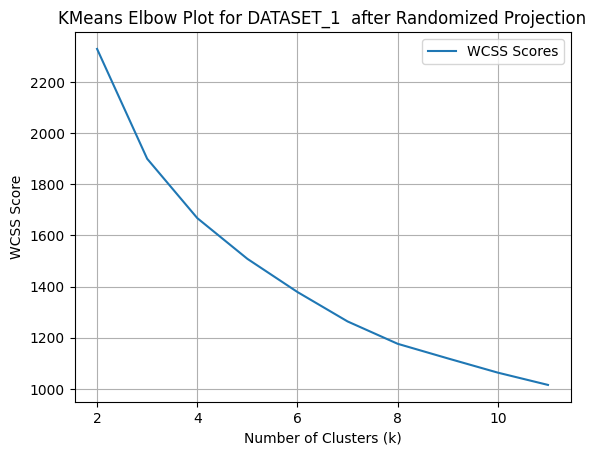

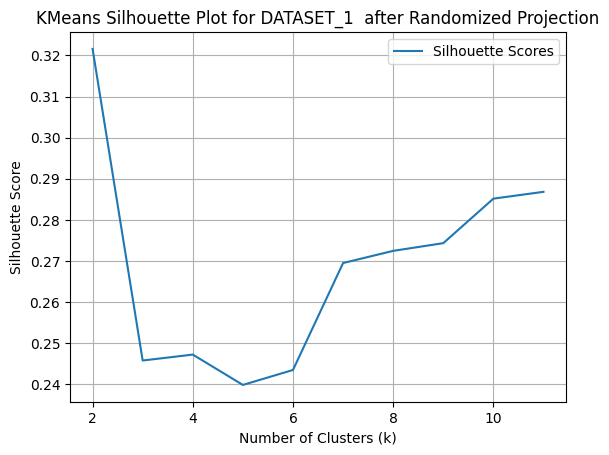

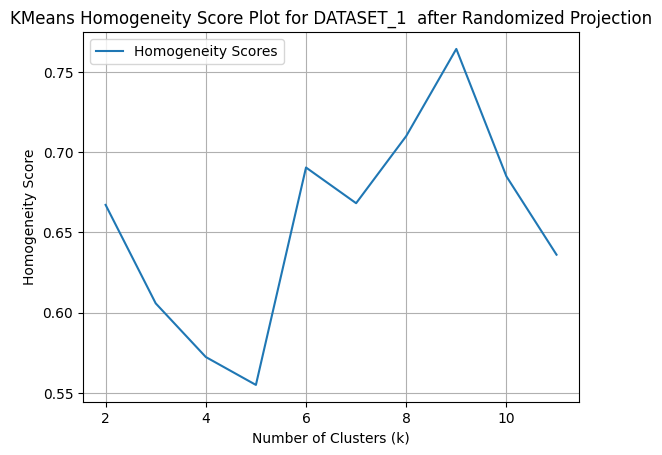

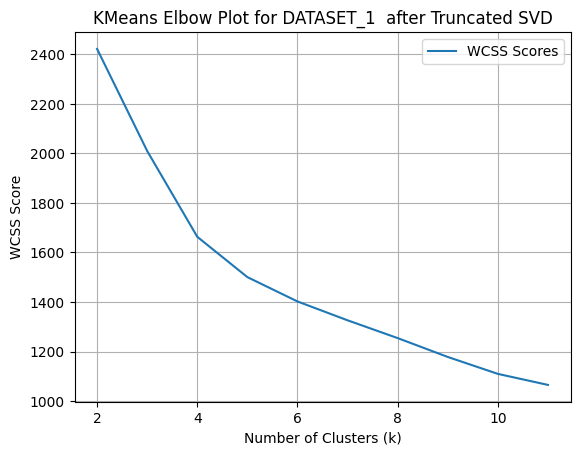

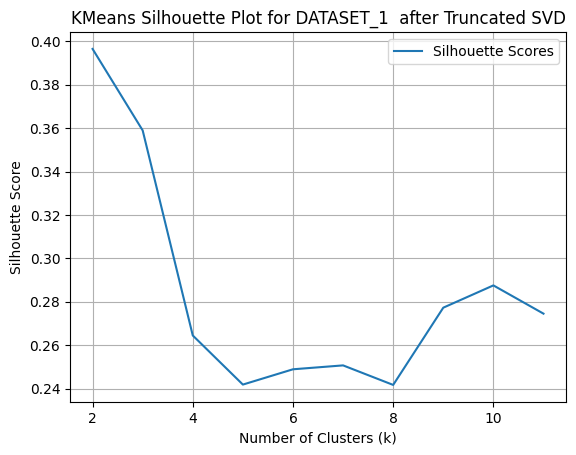

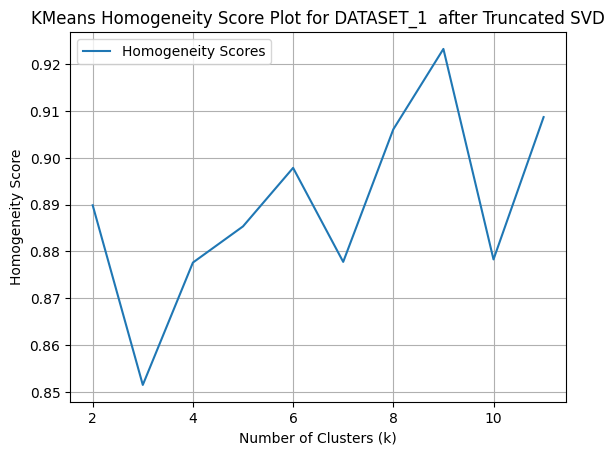

In [59]:
run_kmeans_and_plot(X_train_reduced_pca1, y_train1, DATASET_1, suffix='_part3_pca', title_update=' after PCA')
run_kmeans_and_plot(X_train_reduced_ica1, y_train1, DATASET_1, suffix='_part3_ica', title_update=' after ICA')
run_kmeans_and_plot(X_train_reduced_grp1, y_train1, DATASET_1, suffix='_part3_grp', title_update=' after Randomized Projection')
run_kmeans_and_plot(X_train_reduced_tsvd1, y_train1, DATASET_1, suffix='_part3_svd', title_update=' after Truncated SVD')

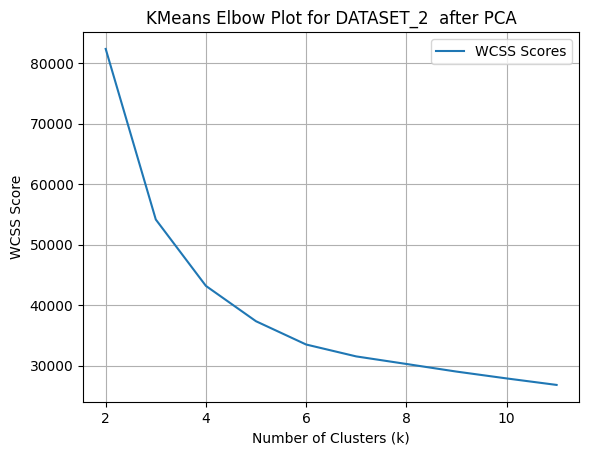

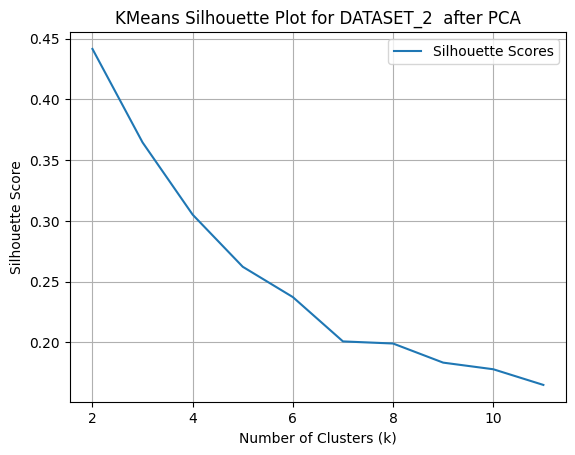

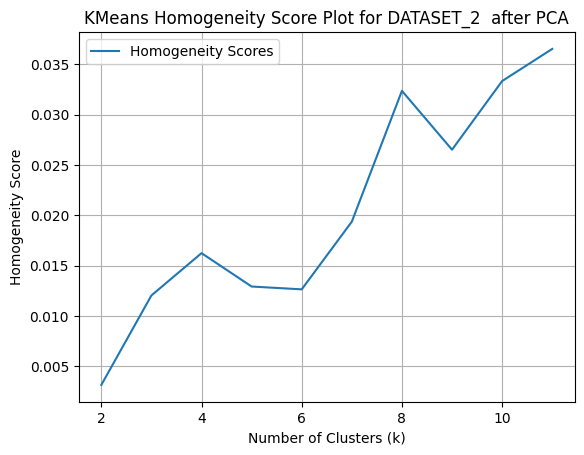

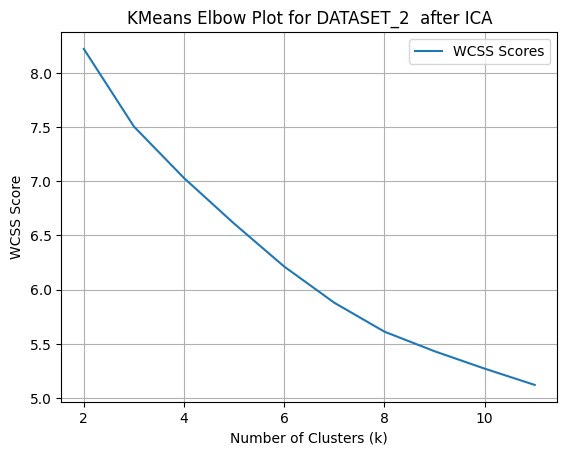

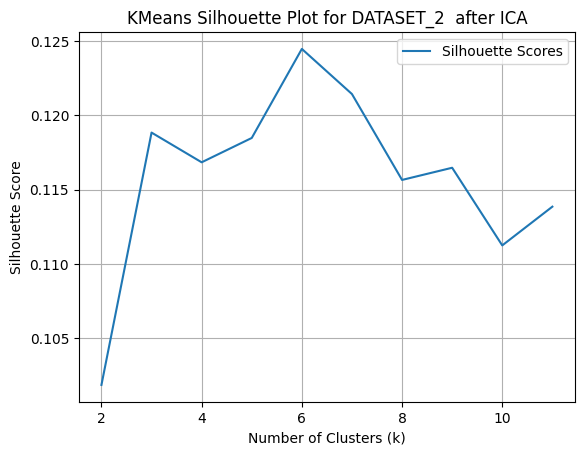

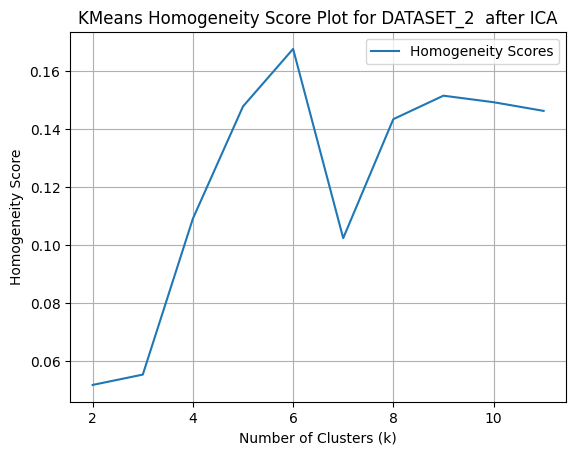

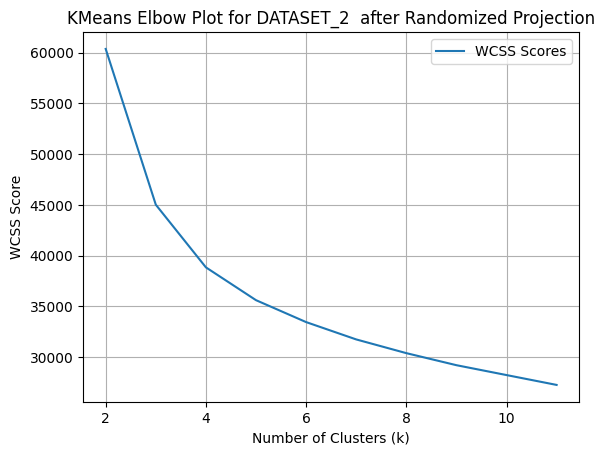

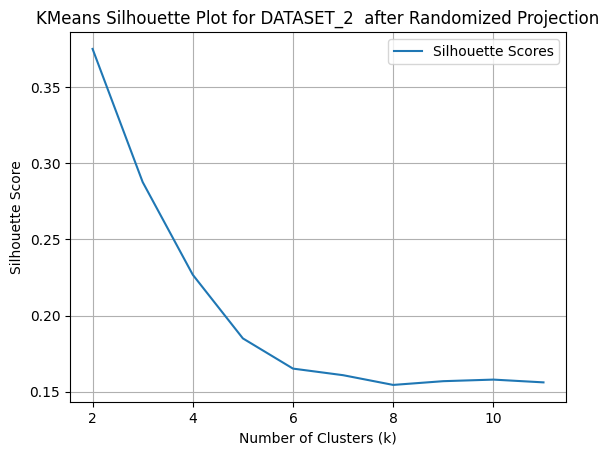

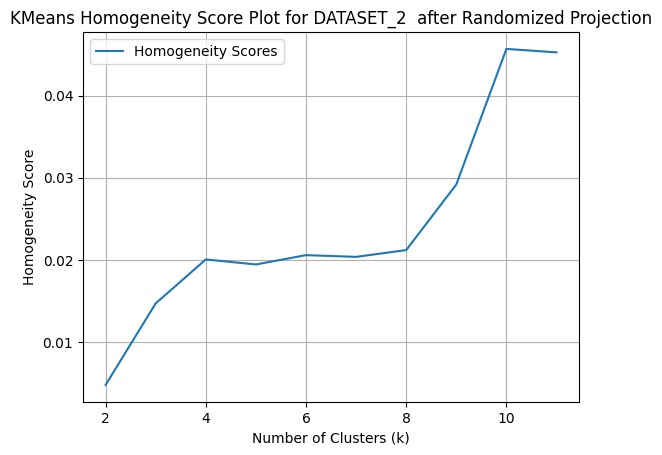

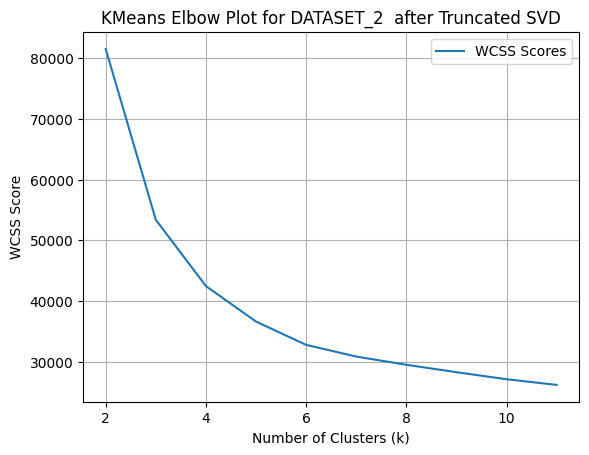

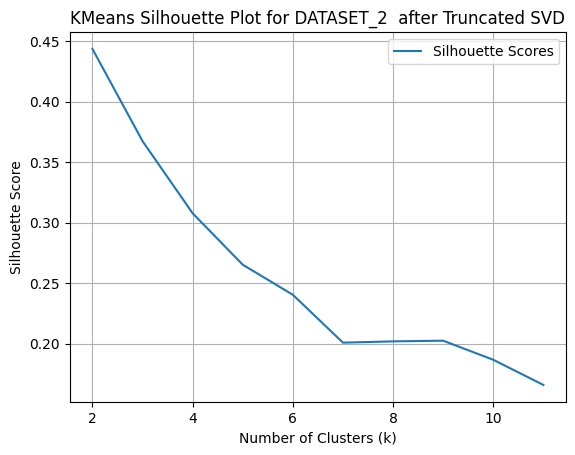

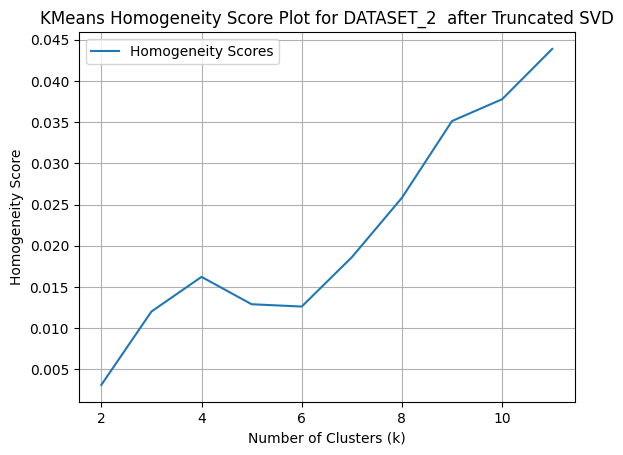

In [60]:
run_kmeans_and_plot(X_train_reduced_pca2, y_train2, DATASET_2, suffix='_part3_pca', title_update=' after PCA')
run_kmeans_and_plot(X_train_reduced_ica2, y_train2, DATASET_2, suffix='_part3_ica', title_update=' after ICA')
run_kmeans_and_plot(X_train_reduced_grp2, y_train2, DATASET_2, suffix='_part3_grp', title_update=' after Randomized Projection')
run_kmeans_and_plot(X_train_reduced_tsvd2, y_train2, DATASET_2, suffix='_part3_svd', title_update=' after Truncated SVD')

### Part 4 and 5 - Neural Networks

In [36]:
def nn_grid_search(X_train):
    inputs = X_train.shape[1]
    layer_size_range = np.arange(1, 2*inputs)
    one_layer_hidden_layer_sizes_range = [(i, ) for i in layer_size_range]
    
    param_grid = {'hidden_layer_sizes': one_layer_hidden_layer_sizes_range,
                  'learning_rate_init': [0.001, 0.01, 0.1, 1],
                  'max_iter': [500, 1000, 2000]
                 }
    grid_search = GridSearchCV(MLPClassifier(random_state=random_seed), param_grid, scoring='f1', n_jobs=4, refit=True, 
                              cv=10, verbose=1, pre_dispatch='2*n_jobs', return_train_score=True)
    grid_search.fit(X_train2, y_train2)
    return grid_search.best_params_

In [37]:
start = time.time()
nn_grid_search_pca1 = nn_grid_search(X_train_reduced_pca1)
print(f'Time taken for grid search for PCA: {time.time() - start}')

start = time.time()
nn_grid_search_ica1 = nn_grid_search(X_train_reduced_ica1)
print(f'Time taken for grid search for ICA: {time.time() - start}')

start = time.time()
nn_grid_search_grp1 = nn_grid_search(X_train_reduced_grp1)
print(f'Time taken for grid search for GRP: {time.time() - start}')

start = time.time()
nn_grid_search_tsvd1 = nn_grid_search(X_train_reduced_tsvd1)
print(f'Time taken for grid search for TSVD: {time.time() - start}')

Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Time taken for grid search for PCA: 309.52240347862244
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Time taken for grid search for ICA: 306.0879690647125
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Time taken for grid search for GRP: 295.77503204345703
Fitting 10 folds for each of 228 candidates, totalling 2280 fits
Time taken for grid search for TSVD: 301.0456004142761


In [39]:
nn_grid_search_pca1

{'hidden_layer_sizes': (18,), 'learning_rate_init': 0.001, 'max_iter': 500}

In [40]:
nn_grid_search_ica1

{'hidden_layer_sizes': (18,), 'learning_rate_init': 0.001, 'max_iter': 500}

In [41]:
nn_grid_search_grp1

{'hidden_layer_sizes': (18,), 'learning_rate_init': 0.001, 'max_iter': 500}

In [42]:
nn_grid_search_tsvd1

{'hidden_layer_sizes': (18,), 'learning_rate_init': 0.001, 'max_iter': 500}

In [43]:
start = time.time()
nn_grid_search_pca2 = nn_grid_search(X_train_reduced_pca2)
print(f'Time taken for grid search for PCA: {time.time() - start}')

start = time.time()
nn_grid_search_ica2 = nn_grid_search(X_train_reduced_ica2)
print(f'Time taken for grid search for ICA: {time.time() - start}')


Fitting 10 folds for each of 204 candidates, totalling 2040 fits
Time taken for grid search for PCA: 265.0354070663452
Fitting 10 folds for each of 204 candidates, totalling 2040 fits
Time taken for grid search for ICA: 263.7518174648285


In [45]:
nn_grid_search_ica2

{'hidden_layer_sizes': (14,), 'learning_rate_init': 0.001, 'max_iter': 500}

In [44]:
nn_grid_search_pca2

{'hidden_layer_sizes': (14,), 'learning_rate_init': 0.001, 'max_iter': 500}

In [65]:
classifier1 = MLPClassifier(hidden_layer_sizes=(18,), learning_rate_init= 0.001, max_iter=500, random_state=random_seed)
classifier2 = MLPClassifier(hidden_layer_sizes=(14,), learning_rate_init= 0.001, max_iter=500, random_state=random_seed)
classifier = classifier1

def run_nn_independent(X_train, y_train, X_test, y_test):
    clf_nn = classifier
    clf_nn.fit(X_train, y_train)
    y_pred = clf_nn.predict(X_test)
    print_metrics('Neural Networks', y_test, y_pred)
    
    
def nn_learning_curve(classifier, X_train, y_train, X_test, y_test, figname='', title_update=''):
    train_sizes = np.arange(0.1, 1.0, .1)
    train_sizes_abs, nn_train_scores, nn_test_scores, nn_fit_times, nn_score_times = learning_curve(classifier, X_train, y_train, train_sizes=train_sizes, 
                                cv=10, n_jobs=4, scoring='f1', shuffle=True, return_times=True, random_state=random_seed)

    title = 'Neural Networks Learning curve for {}'.format(title_update)
    create_curve_mean(x_range=train_sizes, train_scores=nn_train_scores, test_scores=nn_test_scores, train_legend='Training score', test_legend='Test score', 
                 title=title, x_label='% of Training Samples', y_label='F1 score', figname=figname)
    return train_sizes_abs, nn_train_scores, nn_test_scores, nn_fit_times, nn_score_times

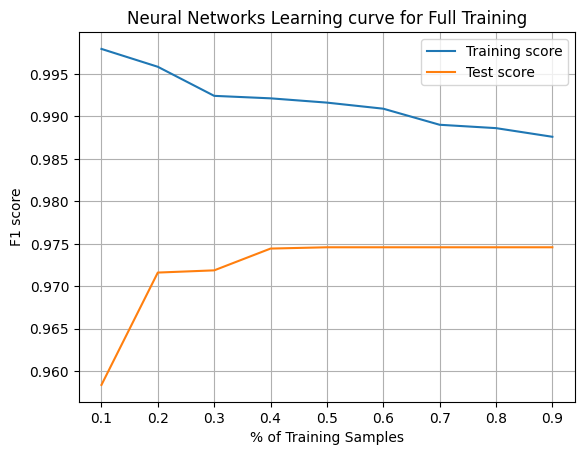

In [67]:
train_sizes_abs1, nn_train_scores1, nn_test_scores1, nn_fit_times1, nn_score_times1 = nn_learning_curve(classifier1,
    X_train1, y_train1, X_test1, y_test1, figname='ds1_nn_learning_curve.png', title_update='Full Training')

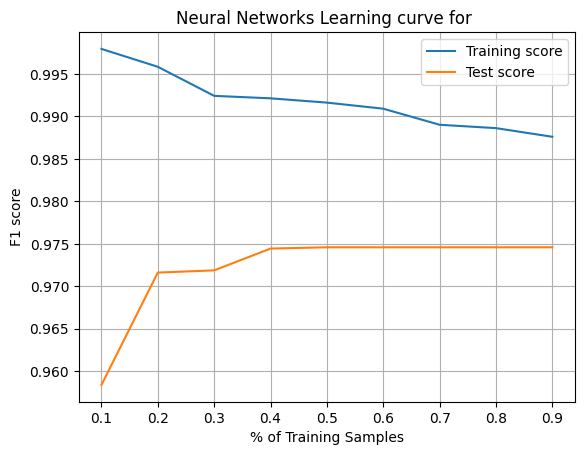

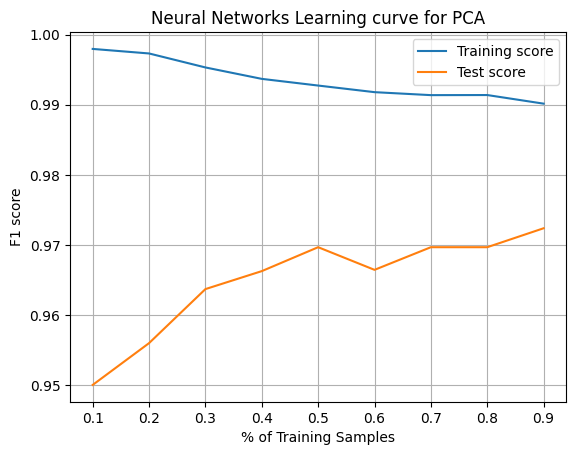

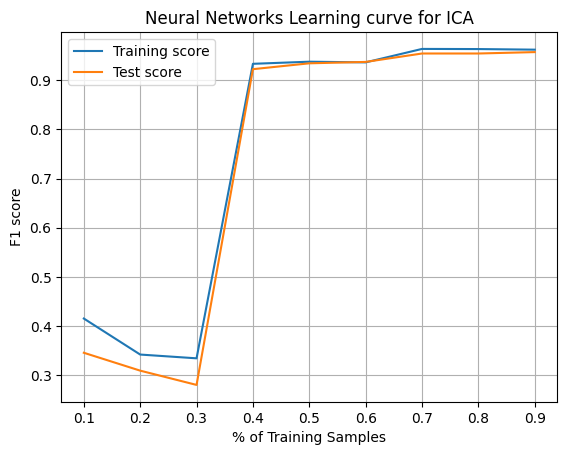

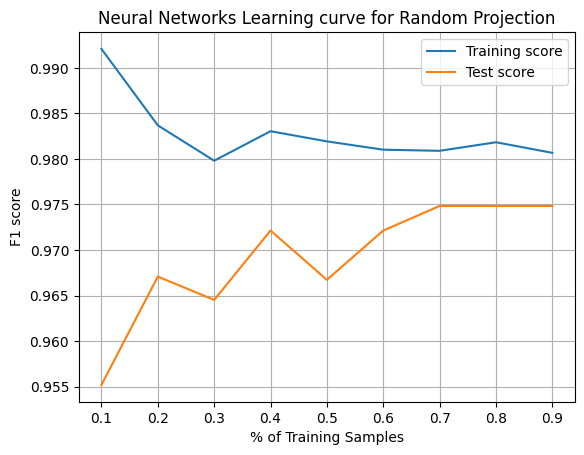

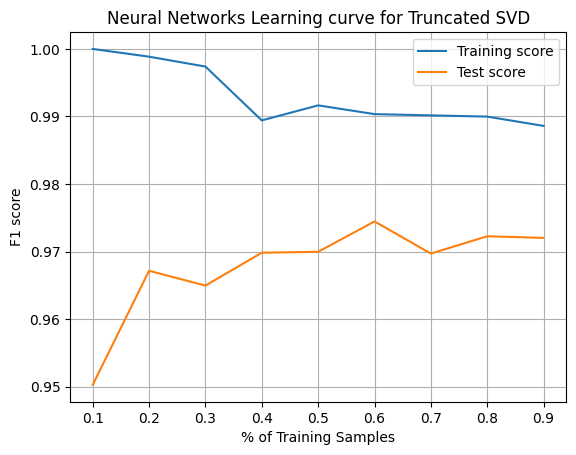

In [66]:
train_sizes_abs_pca1, nn_train_scores_pca1, nn_test_scores_pca1, nn_fit_times_pca1, nn_score_times_pca1 = nn_learning_curve(classifier1,
    X_train_reduced_pca1, y_train1, X_test1, y_test1, figname='ds1_nn_learning_curve_pca.png', title_update='PCA')

train_sizes_abs_ica1, nn_train_scores_ica1, nn_test_scores_ica1, nn_fit_times_ica1, nn_score_times_ica1 = nn_learning_curve(classifier1,
    X_train_reduced_ica1, y_train1, X_test1, y_test1, figname='ds1_nn_learning_curve_ica.png', title_update='ICA')

train_sizes_abs_grp1, nn_train_scores_grp1, nn_test_scores_grp1, nn_fit_times_grp1, nn_score_times_grp1 = nn_learning_curve(classifier1,
    X_train_reduced_grp1, y_train1, X_test1, y_test1, figname='ds1_nn_learning_curve_grp.png', title_update='Random Projection')

train_sizes_abs_tsvd1, nn_train_scores_tsvd1, nn_test_scores_tsvd1, nn_fit_times_tsvd1, nn_score_times_tsvd1 = nn_learning_curve(classifier1,
    X_train_reduced_tsvd1, y_train1, X_test1, y_test1, figname='ds1_nn_learning_curve_tsvd.png', title_update='Truncated SVD')

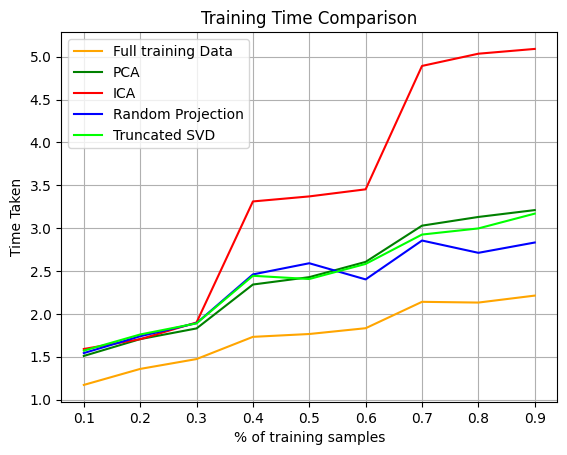

In [70]:
create_time_plot('Training Time Comparison', "% of training samples", "Time Taken", nn_fit_times1, nn_fit_times_pca1, 
                 nn_fit_times_ica1, nn_fit_times_grp1, nn_fit_times_tsvd1, figname='ds1_training_time_comparison.png')

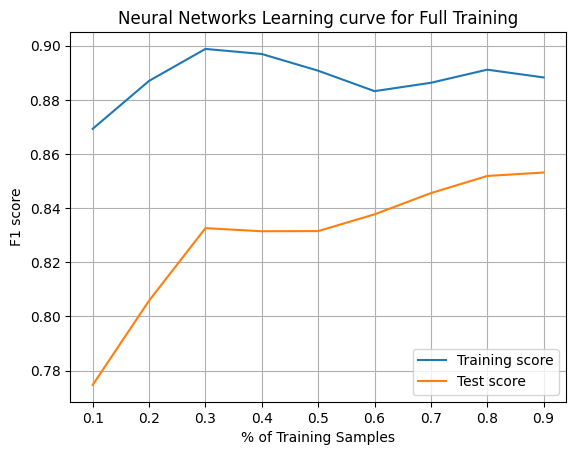

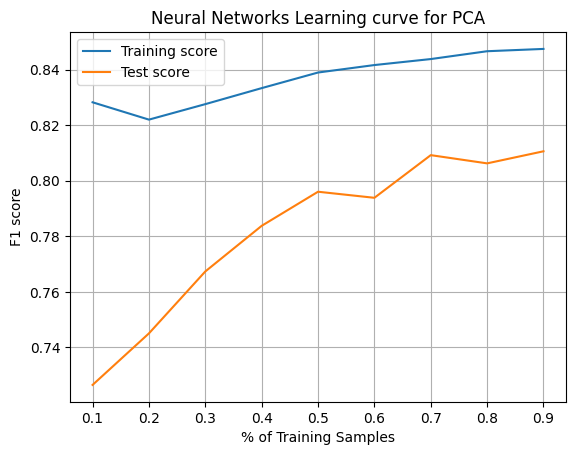

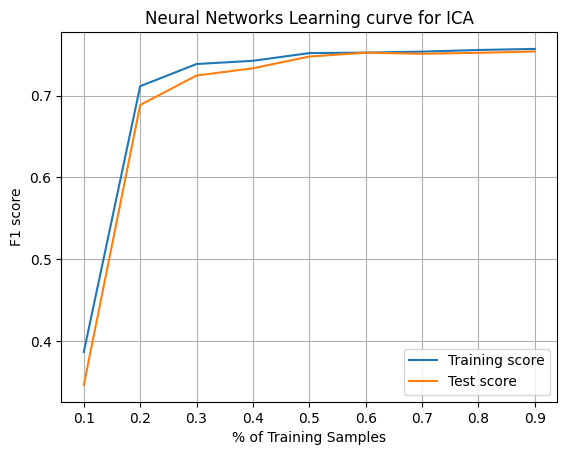

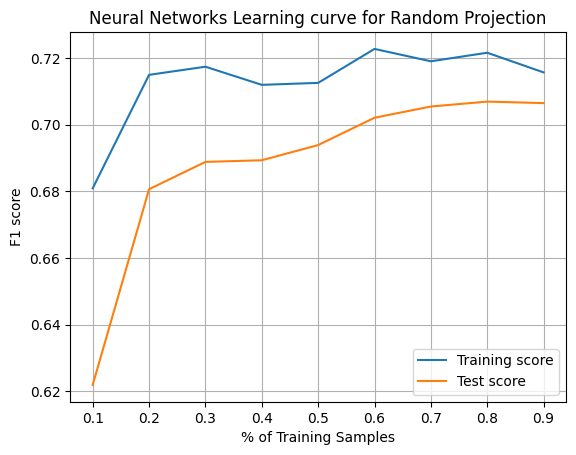

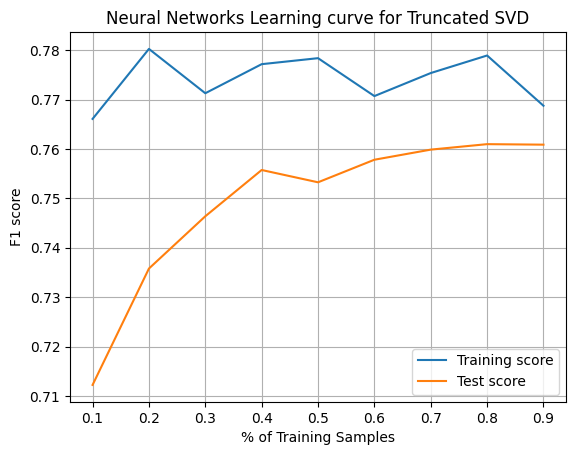

In [73]:
train_sizes_abs2, nn_train_scores2, nn_test_scores2, nn_fit_times2, nn_score_times2 = nn_learning_curve(classifier2,
    X_train2, y_train2, X_test2, y_test2, figname='ds2_nn_learning_curve.png', title_update='Full Training')

train_sizes_abs_pca2, nn_train_scores_pca2, nn_test_scores_pca2, nn_fit_times_pca2, nn_score_times_pca2 = nn_learning_curve(classifier2,
    X_train_reduced_pca2, y_train2, X_test2, y_test2, figname='ds2_nn_learning_curve_pca.png', title_update='PCA')

train_sizes_abs_ica2, nn_train_scores_ica2, nn_test_scores_ica2, nn_fit_times_ica2, nn_score_times_ica2 = nn_learning_curve(classifier2,
    X_train_reduced_ica2, y_train2, X_test2, y_test2, figname='ds2_nn_learning_curve_ica.png', title_update='ICA')

train_sizes_abs_grp2, nn_train_scores_grp2, nn_test_scores_grp2, nn_fit_times_grp2, nn_score_times_grp2 = nn_learning_curve(classifier2,
    X_train_reduced_grp2, y_train2, X_test2, y_test2, figname='ds2_nn_learning_curve_grp.png', title_update='Random Projection')

train_sizes_abs_tsvd2, nn_train_scores_tsvd2, nn_test_scores_tsvd2, nn_fit_times_tsvd2, nn_score_times_tsvd2 = nn_learning_curve(classifier2,
    X_train_reduced_tsvd2, y_train2, X_test2, y_test2, figname='ds2_nn_learning_curve_tsvd.png', title_update='Truncated SVD')

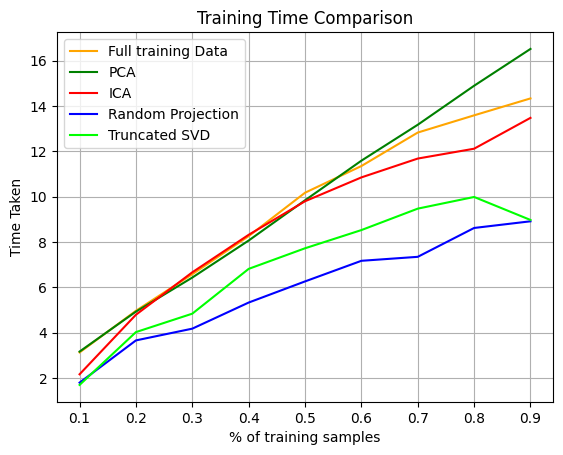

In [74]:
create_time_plot('Training Time Comparison', "% of training samples", "Time Taken", nn_fit_times2, nn_fit_times_pca2, 
                 nn_fit_times_ica2, nn_fit_times_grp2, nn_fit_times_tsvd2, figname='ds2_training_time_comparison.png')

In [147]:
def run_kmeans_step5(X_train, y_train, X_test, y_test):
    kmeans = KMeans(n_clusters=2, max_iter=100, random_state=random_seed)
    X_train = kmeans.fit_transform(X_train, y_train)
    labels_train = kmeans.labels_
    return X_train, labels_train

def run_gaussian_mixture_step5(X_train, y_train, X_test, y_test):
    gmm = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)
    labels = gmm.fit_predict(X_train, y_train)
    return X_train, labels

X_train_kmeans2, labels_train_kmeans2 = run_kmeans_step5(X_train2, y_train2,  X_test2, y_test2)
y_train_gmm2, labels_train_gmm2 = run_gaussian_mixture_step5(X_train2, y_train2,  X_test2, y_test2)

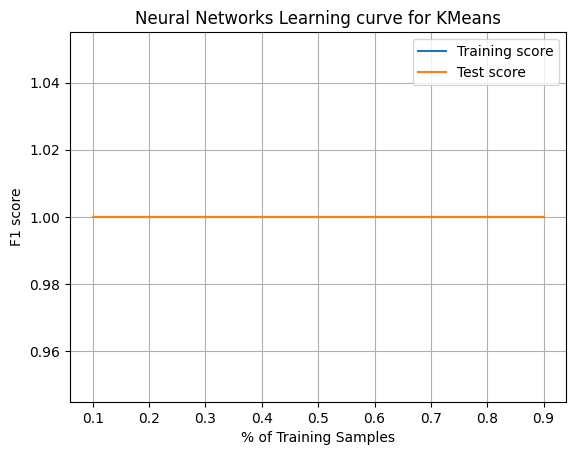

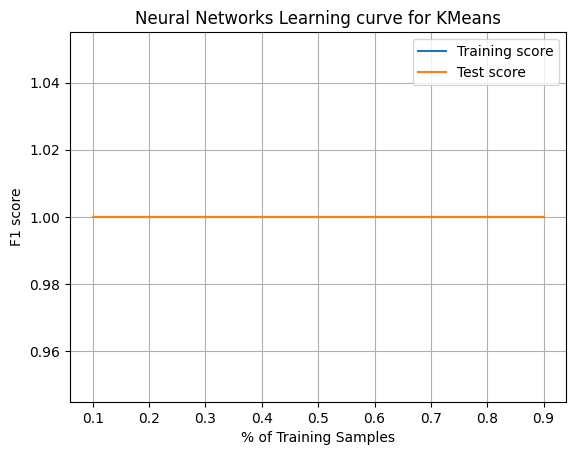

In [148]:
train_sizes_abs_kmeans2, nn_train_scores_kmeans2, nn_test_scores_kmeans2, nn_fit_times_kmeans2, nn_score_times_kmeans2 = nn_learning_curve(classifier2,
    X_train_kmeans2, labels_train_kmeans2, X_test2, y_test2, figname='ds2_nn_learning_curve_kmeans.png', title_update='KMeans')

train_sizes_abs_kmeans2, nn_train_scores_kmeans2, nn_test_scores_kmeans2, nn_fit_times_kmeans2, nn_score_times_kmeans2 = nn_learning_curve(classifier2,
    X_train_kmeans2, labels_train_kmeans2, X_test2, y_test2, figname='ds2_nn_learning_curve_kmeans.png', title_update='KMeans')
